1. Import necessary packages, and read in data
2. Preprocessing data and apriori feature selection
3. Random Forest: model training, tuning, and evaluation
4. Testing it out!

# Import necessary packages, and read in data

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

In [3]:
'''The line below is not code, please make it into code by putting in full path'''
# path = path to Titanic_full in your laptop

'The line below is not code, please make it into code by putting in full path'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = open('/content/drive/MyDrive/dataset_INFO6105/Titanic_full.csv')
df = pd.read_csv(data)
print(df.shape)
df.head(2)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


# 2. Preprocessing data and apriori feature selection

In the broadest sense of the term, preprocessing can also include feature selection. Here, we will use our
rationale to feature select. What do the column names mean, does it make sense to what we are trying to do, and should we keep it or drop it?

There are different ways to think about it. For now, let's drop Name, Cabin and Ticket columns.

Let's see if this makes a difference.

In [6]:
'''Keep aside test data first'''

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


df_trn_val,df_tst = mydf_splitter(df,1150)

print(df_trn_val.shape,df_tst.shape)

(1150, 12) (159, 12)


In [7]:
df_trn_val1 = df_trn_val.drop(["Name","Cabin","Ticket"],axis = 1)
print(df_trn_val1.shape)
df_trn_val1.head(3)

(1150, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S


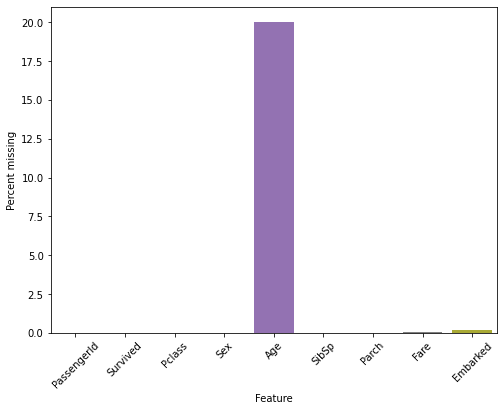

In [8]:
''' Deal with missing values. First, calculate the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = df_trn_val1.isnull().sum()/len(df_trn_val1)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [9]:
#Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [10]:
'''Define impute functions. Impute categorical NaNs with -1, 
where we add 1 to make it 0. For each 
continuous variables, we impute missing values with median values of that
column, and for every variable
where any rows were imputed, add a separate 'imputed or not' column'''

def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [11]:
df_trn_val2 = str_to_cat(df_trn_val1)
print(df_trn_val2.shape)
df_trn_val2.head(3)

(1150, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S


In [12]:
df_trn_val3,my_table = mydf_preprocessor(df_trn_val2,null_table = None)
print(df_trn_val3.shape)
df_trn_val3.head(3)

(1150, 11)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_na,Fare_na
0,1,0,3,2,22.0,1,0,7.2500,3,False,False
1,2,1,1,1,38.0,1,0,71.2833,1,False,False
2,3,1,3,1,26.0,0,0,7.9250,3,False,False


In [13]:
my_table

{'Age': 28.0, 'Fare': 14.4542}

In [14]:
x = df_trn_val3.drop('Survived', axis=1)
y = df_trn_val3['Survived']

In [39]:
x_trn, x_val, y_trn, y_val = train_test_split(x, y, random_state=1)
print(x_trn.shape,x_val.shape,y_trn.shape,y_val.shape)

(862, 10) (288, 10) (862,) (288,)


# Random Forest: To find the best n_estimators

In [23]:
# Using Validation Curve

In [19]:
param_range = np.arange(1, 250, 2)

In [20]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = x_trn, y = y_trn, 
                                param_name = 'n_estimators', 
                                param_range = param_range, cv = 3)

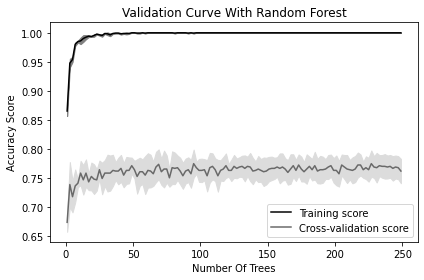

In [22]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [24]:
# Using GridSearchCV

In [29]:
rfc=RandomForestClassifier(random_state=42)

In [30]:
param_grid = { 
    'n_estimators': [200, 500, 750, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [32]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_trn, y_trn)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500, 750, 1000]})

In [34]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 200}

In [ ]:
# RandomizedSearchCV

In [42]:
rf_RandomGrid = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)

In [46]:
rf_RandomGrid.fit(x_trn, y_trn)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [200, 500, 750, 1000]},
                   verbose=2)

In [47]:
rf_RandomGrid.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 500}

In [ ]:
mod_1 = RandomForestClassifier(n_jobs = -1, n_estimators = 10,
                                 bootstrap = True)
mod_1.fit(x_trn,y_trn)

RandomForestClassifier(n_estimators=10, n_jobs=-1)

In [ ]:
y_prd = mod_1.predict(x_val)
accuracy_score(y_val,y_prd)

0.7256944444444444

In [ ]:
mod_2 = RandomForestClassifier(n_jobs = -1, n_estimators = 1000,
                                 bootstrap = True)
mod_2.fit(x_trn,y_trn)
y_prd2 = mod_2.predict(x_val)
accuracy_score(y_val,y_prd2)

0.7465277777777778

In [ ]:
mod_3 = RandomForestClassifier(n_jobs = -1, n_estimators = 1000,max_features = 0.25,
                               bootstrap = True)
mod_3.fit(x_trn,y_trn)
y_prd3 = mod_3.predict(x_val)
accuracy_score(y_val,y_prd3)

0.7465277777777778

# 4.  Testing it out!

In [ ]:
'''Preprocess test set exactly like the train and validation sets'''

df_tst1 = df_tst.drop(["Name","Cabin","Ticket"],axis = 1)
print(df_tst1.shape)
df_tst1.head(3)

(159, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1150,1151,1,3,male,21.0,0,0,7.7750,S
1151,1152,0,3,male,36.5,1,0,17.4000,S
1152,1153,1,3,male,21.0,0,0,7.8542,S


In [ ]:
df_tst2 = str_to_cat(df_tst1)
df_tst2.Sex.cat.categories

Index(['female', 'male'], dtype='object')

In [ ]:
df_tst2,my_table1 = mydf_preprocessor(df_tst1,
                                         null_table = my_table)
print(df_tst2.shape)
df_tst2.head(3)

(159, 11)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_na,Fare_na
1150,1151,1,3,2,21.0,0,0,7.7750,3,False,False
1151,1152,0,3,2,36.5,1,0,17.4000,3,False,False
1152,1153,1,3,2,21.0,0,0,7.8542,3,False,False


In [ ]:
# Now, let's split out the X and Y variables (vertical split of the dataframe)
#Remember we did this previously!


y_tst = df_tst2["Survived"]
x_tst = df_tst2.drop(["Survived"],axis = 1)

print(x_tst.shape,y_tst.shape)

(159, 10) (159,)


In [ ]:
y_prd_tst = mod_1.predict(x_tst)
accuracy_score(y_tst,y_prd_tst)

0.5094339622641509

In [ ]:
'''Looks like we are improving! With a dataset of this size, best way forward is more
feature engineering. Take a look at all the Kaggle solutions to this competition and
all the different feature engineering methods! When we get to Neural Networks'''

'Looks like we are improving! With a dataset of this size, best way forward is more\nfeature engineering. Take a look at all the Kaggle solutions to this competition and\nall the different feature engineering methods! When we get to Neural Networks'